<a href="https://colab.research.google.com/github/simodepth96/Data-Science-Portfolio/blob/main/Anomaly_Detection_Univariate_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains relevant processes to conduct a **univariate time-series anomaly detection**.

In time-series, anomalies are data points that deviate significantly from the underlying pattern of the time series.

Anomalies can be referred to as **outliers**

> **Outliers** are extreme values sitting 3 standard deviations away from the mean.

When a group of anomalies(outliers) are identified, they are classed  as a **window**. If the anomalous group move or repurpose over time, they are referred to as *rolling windows*

**Rolling windows** are leveraged by anomaly detection algorithms to capture subset of extreme data points over time.

##Process
Anomaly detection of a univariate time series requires pre-emptive data cleaning and potential data wrangling operations to crerate or amend variables (feature engineering)

1. Install dependencies (python)
2. Import Univariate time series (XLSX file)
3. Inspect **Missing Data**.
4. **Data points Distribution** - normality or asymettry will instruct on the techniques required to advance with anomaly detection
5. **Data Transformation** - grouped purchase revenue by date to reduce unwanted data dispersion. Each `date` in the dataset corresponds to the cumulative sum of `purchase revenue` for each sessions (includes all marketing channels)
6. **Time Series Decomposition** - overview and simplify time series analysis
7. **Anomaly Detection** (Comparing Windows with ADTK - PersistAD)
7. TEST - Purchase Revenue Trend Before Applying Outliers Removal
8. **Outliers Removal** using IQR rule
9. **Purchase Revenue Trend with Moving Average**



In [67]:
!pip install plotly
!pip install adtk

#operational libraries
import pandas as pd
import numpy as np
import datetime
from datetime import datetime

#data viz
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
import seaborn as sns

#anomaly detection
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import PersistAD

#timeseries decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

#drawing trendlines
from scipy.stats import linregress
from scipy.stats import zscore


In [68]:
df = pd.read_excel('/content/sitemap_url_non_indicizzabili_nella_sitemap.xlsx', parse_dates=['Date'], sheet_name='data')

# Format the dates as DD/MM/YYYY
df['Date'] = pd.to_datetime(df['Date'])

# Convert 'purchase revenue' to integers for accuracy
df['Purchase revenue'] = df['Purchase revenue'].astype(int).round(2)

#Normalize column names
df.columns = map(str.lower, df.columns)
column_names = df.columns.tolist()

print(len(df))
df.head()

7012


,date,purchase revenue
0,2021-09-21,1638
1,2021-09-21,627
2,2021-09-21,528
3,2021-09-21,8
4,2021-09-21,5


#Missing Data
---

- **Missing Completely at Random (MCAR)**= no logical reason why data is missing. Pure chance.

- **Missing at Random** = systematic relationship between missing values and the observed data.
**P(A|B) = P(A)**
So here missing values exist due to another variable in your dataset.

- **Missing Not at Random (MNAR)**: missing data due to a human error.


##Deletion of Missing Data?
One drawback of deleting missingness from a dataset is to introduce biases into the dataset.


However, it is normally safe to delete Missing data when:
- They’re either MAR (e.g no-index pages ⇒ no meta descriptions = I don’t need this) or MCAR (we can prove there is no logical reason for the missingness - e.g a third-party tool glitch)

- MAR and MCAR have a low correlation with other features in the data. If missing data are not important for what I’m doing, I can safely delete them


##Types of deletion
Depending on the kind of analysis we are doing, we have two available kinds of deletion available to us:
- **Listwise** : it removes the entire observation when there is missing data. Apply when the number of rows with missing data is relatively small to avoid significant bias.

- **Pairwise**: it removes rows when there are missing values in the variables we are directly analyzing.Apply when the number of rows with missing data is relatively larger. This is helpful to limit the margin of error during data wrangling

##How much can you Delete?

1. If **less than 20% of data is missing**, then we are safe to use **listwise** deletion
1. If **20%-60% of data is missing**, then we are safe to use **pairwise** deletion
3. If **more than 80% of data is missing**, then we are safe to use **drop columns** deletion


In [69]:
#@title Missing data
df.isna().sum() # no missing data!

,0
date,0
purchase revenue,0


In [70]:
#@title Min and Max points
print(df.describe().loc[['min', 'max']])

#purchase revenue hit a 0 on some occasions!

                    date  purchase revenue
min  2021-09-21 00:00:00               0.0
max  2024-11-13 00:00:00           52843.0


In [71]:
#@title Purchase Revenue Line Chart
fig = go.Figure(data=go.Scatter(x=df['date'], y=df['purchase revenue'], mode='lines'))
fig.update_layout(title='Purchase Revenue Trend',
                  xaxis_title='Date',
                  yaxis_title='Purchase Revenue')
fig.show()

#Data Transformation

Grouping the sum of purchase revenue by date will ease us into the anomaly detection process with a dataset where each date corresponds to a revenue figure.

In [104]:
pivot = df.pivot_table(
    values='purchase revenue',
    index='date',
    aggfunc='sum'
).sort_index()

grouped_purchase = pivot.reset_index()

#renaming cols
grouped_purchase.columns = ['date', 'purchase revenue']
column_names = grouped_purchase.columns.tolist()

print(len(grouped_purchase))
grouped_purchase.head()

1122


,date,purchase revenue
0,2021-09-21,2808
1,2021-09-22,5851
2,2021-09-23,5026
3,2021-09-24,1857
4,2021-09-25,8351


#(TEST) Purchase Revenue Trend - Before Outliers Removal (TEST)

In [78]:
#@title Draw a Trendline

# Generate a trendline using linear regression
slope, intercept, r_value, p_value, std_err = linregress(
    pd.to_datetime(grouped_purchase['date']).map(pd.Timestamp.toordinal),
    grouped_purchase['purchase revenue']
)

# Calculate the trendline values
trendline = slope * pd.to_datetime(grouped_purchase['date']).map(pd.Timestamp.toordinal) + intercept

In [79]:
#@title Trend Fatturato Twinset - Pre rimozione Outliers

#applying the moving average to further smooth out residuals
grouped_purchase['purchase revenue'] = grouped_purchase['purchase revenue'].rolling(window=12, center=True).mean().fillna(grouped_purchase['purchase revenue'])

fig = go.Figure()

# Add the Smoothed Data line
fig.add_trace(go.Scatter(
    x=grouped_purchase['date'],
    y=grouped_purchase['purchase revenue'],
    mode='lines+markers',
    name='Dati Raw',
    line=dict(color='red')
))

# Add the trendline
fig.add_trace(go.Scatter(
    x=grouped_purchase['date'],
    y=trendline,
    mode='lines',
    name='Trend',
    line=dict(color='blue', dash='dash')
))

# Add annotations on the bottom-right side
fig.update_layout(
    title='Trend Fatturato Twinset - Pre rimozione Outliers',
    xaxis_title='Date',
    yaxis_title='Purchase Revenue',
    template='plotly_white',
    width=1400,
    height=500
)

# Show plot
fig.show()


#Time Series Decomposition

Breaking a time series into its components simplifies the analysis by offering insights into the long-term direction (trend), recurring patterns (seasonality), and unpredictable variations (residuals)

This decomposition provides a clearer understanding of the underlying structure of the data and helps us grasp errors and potential seasonal effects.

Time Series Models
1.	**Additive Model**: Suitable for dataset with constant seasonal effects, changes are always constant. Use this model if the seasonal variations are roughly constant in magnitude

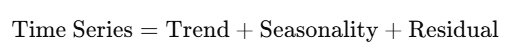

2.	**Multiplicative Model**: For large seasonal variations that grow with the level of the series, and changes over time are visible.

Decomposition of a time series leads to the following separate charts:
- **Trend**: Long-term progression or direction of the data.
- **Seasonal**: Regular, repeating patterns based on the specified period.
- **Residual**: Random noise or irregular components not explained by trend or seasonality.

> **Residuals** are the differences between the observed values and the values predicted by the model.

When a model has too many residuals falling too distant from the mean, the model is *underfitting* as it may miss key trends, seasonality, or relationships between variables.

Removing noise involves filling up/removing missing data, transforming your data into new variables (Feature engineering) or simply resampling the original dataset

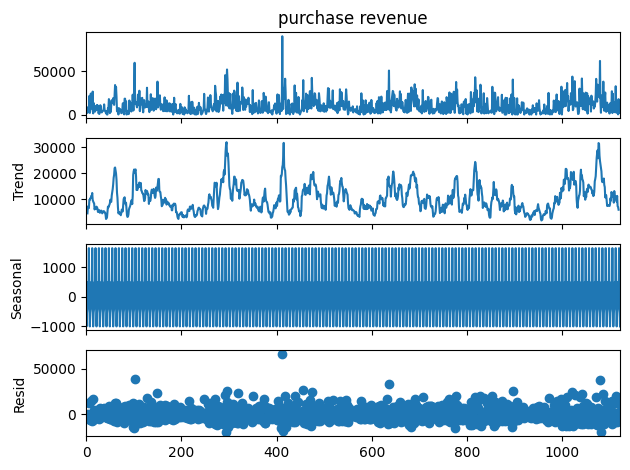

In [105]:
#@title RE-RUN DATA TRANSFORMATION PIVOT TABLE BEFORE THIS CELL!!!
result = seasonal_decompose(grouped_purchase['purchase revenue'], model='additive', period=7)
#If data recorded daily, and you want to analyze weekly seasonality (period=7)
#If data recorded monthly, and you want to analyze yearly seasonality (period=12)
result.plot()
pyplot.show()

###Comment

- **Seasonality is consistent** as it reveals recurring variations each week (period=7 as data are recorded daily!)

- **Significant dispersion of residuals**. These points may be periods with unusual purchase revenue that don't align with the expected seasonal pattern or trend

##Data Distribution
This step is helpful in informing the most suitable anomaly removal approach depending on the shape of the distribution curve for the **purchase revenue** series.


- Normal distribution > Z-score model
- Asymmetric distribution > moving average (*)

the distribution is right-skewed - data points do not follow a normal distribution


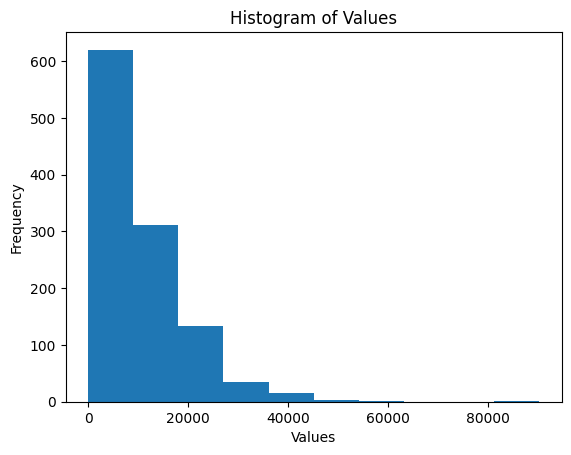

In [83]:
plt.hist(grouped_purchase['purchase revenue'], bins=10)  # Adjust bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
print(f"the distribution is right-skewed - data points do not follow a normal distribution")
plt.show()

#Anomaly Detection

Anomaly detection algorithms operate by utilizing rolling windows that capture a subset of data points over time.

These windows serve as a basis for computing various aggregations such as variance, **mean, and median**.

By evaluating the statistical properties of the data within these windows, the algorithms can identify deviations or unexpected patterns.

An approach to measuring anomalies involves **comparing two windows of data**. The following methods benchmark the next value to a window of values that came up before.

1. **LevelshiftAD**: This method detects anomalies based on **significant shifts** in the level of the metric values. It compares the current value with the median or mean of the previous window.
2. **PersistAD**: The PersistAD method identifies persistent anomalies that **persist** across consecutive windows. It evaluates the ratio of the current value to the median or mean of the previous window.
3. **VolatilityShiftAD**: This method detects anomalies based on significant **changes in the variability of the metric values**. It compares the current value’s volatility with that of the previous window.

##Removal techniques

- **Z-score** is a statistical measure that quantifies the number of standard deviations a data point is away from the mean. In time series data, the Z-score can be calculated for each data point and compared to a predefined threshold. Points that exceed this threshold are flagged as anomalies. **particularly effective when the data follows a normal distribution**.

- **Moving average and exponential smoothing** are techniques used to smooth out noise and fluctuations in time series data. These methods are especially **effective in data that do not follow a normal distribution and has seasonal patterns.**

- **Isolation Forest** is an unsupervised machine learning algorithm that works by isolating anomalies in data. It constructs random decision trees to partition the data, and anomalies are likely to require fewer splits to be isolated. **This method is efficient and effective, especially for high-dimensional data**.

###**Anomaly Detection and Removal Techniques - Next Steps**

1. Residuals have been found in great capacity far off the mean. **PersistAD** model from ADTK will be leveraged to track down anomaly windows.

2. **Seasonality** is consistent and seemingly spans through weekly cycles. Moving average will be leveraged to further smooth out residuals.

3. **Distribution is asymettric**, hence outliers/anomalies have a significant weight on the time series trends. Proceeding with employing a moving average instead of Z-score seems more efficient.

/usr/local/lib/python3.10/dist-packages/adtk/detector/_detector_1d.py:270: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.10/dist-packages/adtk/detector/_detector_1d.py:141: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.

/usr/local/lib/python3.10/dist-packages/adtk/aggregator/_aggregator.py:211: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.



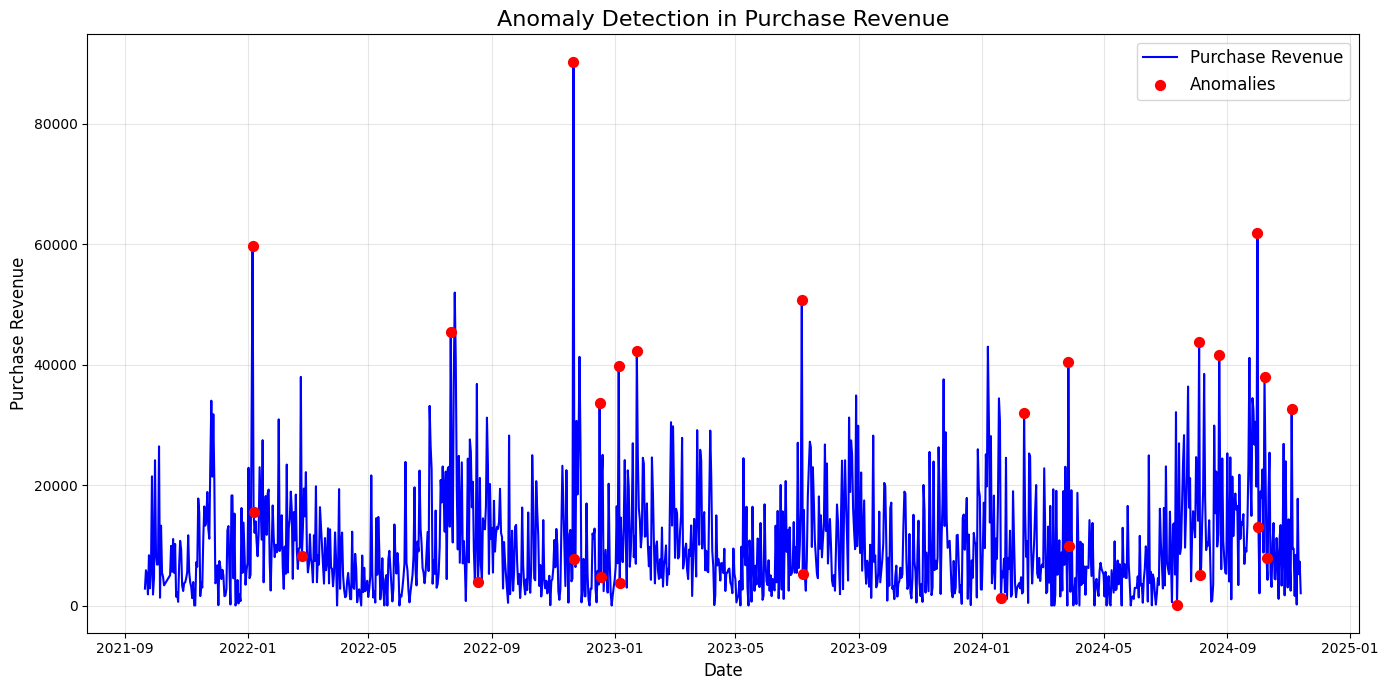

In [84]:
#@title Anomaly Detection - PersistAD

grouped_purchase['date'] = pd.to_datetime(grouped_purchase['date'])
grouped_purchase.set_index('date', inplace=True)

# Validate the series for anomaly detection
s = validate_series(grouped_purchase['purchase revenue'])

# Use PersistAD to detect anomalies (both negative and positive)
persist_ad = PersistAD(c=2, side='both')
anomalies = persist_ad.fit_detect(s)

# Plot the time series with anomalies using Matplotlib
plt.figure(figsize=(14, 7))

# Plot the baseline (original time series)
plt.plot(s.index, s, label='Purchase Revenue', color='blue', linewidth=1.5)

# Overlay the anomalies on the same plot
anomaly_indices = anomalies[anomalies == True].index
plt.scatter(anomaly_indices, s[anomaly_indices], color='red', label='Anomalies', s=50, zorder=5)

# Add labels, legend, and grid
plt.title('Anomaly Detection in Purchase Revenue', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Purchase Revenue', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()


In [85]:
#@title Visualize Outliers
import plotly.express as px

fig = px.violin(grouped_purchase, y='purchase revenue', points="all")
fig.show()

In [86]:
#@title Purchase revenue - 1.5 IQR rule to detect outliers
Q3 = 14484
Q1 = 3829

IQR = grouped_purchase['purchase revenue'].quantile(0.75) - grouped_purchase['purchase revenue'].quantile(0.25)

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

# Calculate standard deviation
ni_std = grouped_purchase['purchase revenue'].std()
print(f"The std is {ni_std}")

# Detect outliers
ni_outliers = grouped_purchase[(grouped_purchase['purchase revenue'] < lower_bound) | (grouped_purchase['purchase revenue'] > upper_bound)]

# Print the outliers
print(ni_outliers['purchase revenue'])


The std is 9172.511601792216
date
2021-11-26    34010
2021-11-28    31761
2022-01-06    59701
2022-02-01    30910
2022-02-23    37961
2022-07-01    33149
2022-07-22    45339
2022-07-25    37000
2022-07-26    51962
2022-07-27    40871
2022-08-17    36794
2022-08-27    31193
2022-11-21    90329
2022-11-24    30660
2022-11-27    41296
2022-12-17    33595
2023-01-05    39702
2023-01-23    42292
2023-02-26    30442
2023-07-06    50734
2023-08-22    31214
2023-08-29    34879
2023-11-24    37557
2024-01-07    42980
2024-01-08    30841
2024-01-18    34397
2024-01-19    30613
2024-02-12    31978
2024-03-27    40354
2024-07-12    32107
2024-07-24    36362
2024-08-04    43747
2024-08-09    38456
2024-08-24    41590
2024-09-23    41127
2024-09-26    34441
2024-09-27    32576
2024-09-29    30511
2024-10-01    61817
2024-10-08    37958
2024-11-04    32627
Name: purchase revenue, dtype: int64


In [48]:
#@title Calculate the Weight of Outliers within the feature

total_values = len(grouped_purchase['purchase revenue'])

percentage_outliers = (len(ni_outliers) / total_values) * 100

print(f"Outliers weight on purchase revenue: {percentage_outliers:.2f}%")

Outliers weight on purchase revenue: 3.65%


In [106]:
#@title Define function to remove outliers

def remove_outlier_IQR(dfWithOutliers):
    Q1=dfWithOutliers.quantile(0.25)
    Q3=dfWithOutliers.quantile(0.75)
    IQR=Q3-Q1
    df_final=dfWithOutliers[~((dfWithOutliers<(Q1-1.5*IQR)) | (dfWithOutliers>(Q3+1.5*IQR)))]
    return df_final

# Removing outliers introduced null values
dfOutliers=grouped_purchase.copy()
dfOutliers=remove_outlier_IQR(grouped_purchase)

In [107]:
#@title Purchased revenue Dispersion - free from anomalies

fig = px.violin(dfOutliers, y='purchase revenue', points="all")
fig.show()

In [51]:
#@title Review Missing Data
maxRows = dfOutliers['date'].count() #this is the first header in the index

print('% Missing Data:')
print((1 - dfOutliers.count() / maxRows) * 100)

% Missing Data:
date                0.000000
purchase revenue    3.654189
dtype: float64


In [108]:
#@title Listwise deletion
'''
we apply listwise deletion due to data points missing for less than 20% of the dataset
'''
dfOutliers.dropna(inplace=True)
print(f'the number of rows is {dfOutliers.shape[0]}')
print(f'missing data is {dfOutliers.isna().sum().sum()}')

# Convert 'purchase revenue' to integers for accuracy
dfOutliers['purchase revenue'] = dfOutliers['purchase revenue'].astype(int)

#Post anomalies removal
dfOutliers.head()

the number of rows is 1081
missing data is 0


,date,purchase revenue
0,2021-09-21,2808
1,2021-09-22,5851
2,2021-09-23,5026
3,2021-09-24,1857
4,2021-09-25,8351


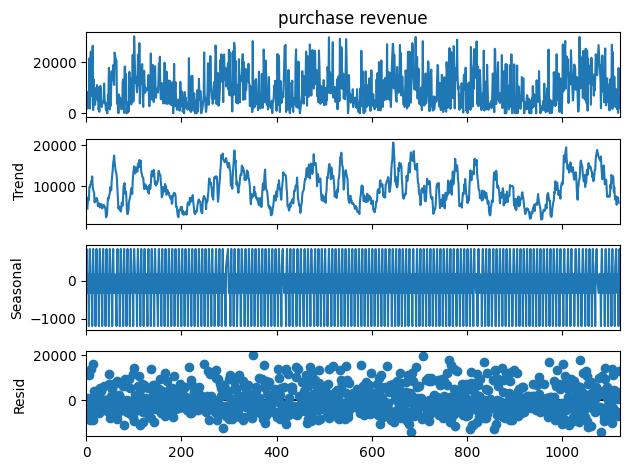

In [109]:
#@title Time Series Decomposition - Cleaned Data
result = seasonal_decompose(dfOutliers['purchase revenue'], model='additive', period=7)
#If data recorded daily, and you want to analyze weekly seasonality (period=7)
#If data recorded monthly, and you want to analyze yearly seasonality (period=12)
result.plot()
pyplot.show()

##**Comment**
1. The purchase revenue **trend** looks promising especially with reference to the latest cycles of sale
2. **Seasonality** is still consistent as a strong indication purchase revenue follows recurring patterns each week (i.e; the highest revenue points are generated every weekend)
3. **Residuals** have been limited meaning that the variance of the data points is reduced.

#Purchase Revenue Trend - Plotting with Moving Average Applied

In [110]:
#@title Draw a Trendline

# Generate a trendline using linear regression
slope, intercept, r_value, p_value, std_err = linregress(
    pd.to_datetime(dfOutliers['date']).map(pd.Timestamp.toordinal),
    dfOutliers['purchase revenue']
)

# Calculate the trendline values
trendline = slope * pd.to_datetime(dfOutliers['date']).map(pd.Timestamp.toordinal) + intercept

In [111]:
#apply moving average to smooth out potential fluctuations
dfOutliers['purchase revenue'] = dfOutliers['purchase revenue'].rolling(window=12, center=True).mean().fillna(dfOutliers['purchase revenue'])

fig = go.Figure()

# Add the Smoothed Data line
fig.add_trace(go.Scatter(
    x=dfOutliers['date'],
    y=dfOutliers['purchase revenue'],
    mode='lines+markers',
    name='Dati smussati',
    line=dict(color='red')
))

# Add the trendline
fig.add_trace(go.Scatter(
    x=dfOutliers['date'],
    y=trendline,
    mode='lines',
    name='Trend',
    line=dict(color='blue', dash='dash')
))

# Add annotations on the bottom-right side
fig.update_layout(
    title='Trend Fatturato Twinset',
    xaxis_title='Date',
    yaxis_title='Purchase Revenue',
    template='plotly_white',
    width=1400,
    height=500,
    annotations=[
        dict(
            xref="paper",
            yref="paper",
            x=1,  # Position at the right side
            y=1,  # Slightly lower than the first annotation
            xanchor="right",
            yanchor="bottom",
            showarrow=False,
            text="* Tutti i canali. Media mobile fatturato cumulato giornaliero. 21/09/2021 - 14/11/2024",
            font=dict(size=10)
        )
    ]
)

# Show plot
fig.show()
